In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.8/148.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.7/170.7 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0


In [3]:
# 제출 파일 생성 관련
import os
import zipfile

# 데이터 처리 및 분석
import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm

# 머신러닝 전처리
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# 머신러닝 모델
import xgboost as xgb

# 합성 데이터 생성
from sdv.metadata import SingleTableMetadata
from sdv.single_table import TVAESynthesizer
import matplotlib.pyplot as plt

# To ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 데이터 불러오기
path = '/content/drive/MyDrive/Colab Notebooks/fsi/open/'
save_path = '/content/drive/MyDrive/Colab Notebooks/fsi/processed_data/1_30_sample_pre_syn.csv'

train_all = pd.read_csv(path + "train.csv")
test_all = pd.read_csv(path + "test.csv")
saved_train = pd.read_csv(save_path)

train = train_all.drop(columns="ID")
saved_train["Fraud_Type"].value_counts()

,count
Fraud_Type,
m,30
a,30
j,30
h,30
k,30
c,30
g,30
i,30
b,30


In [5]:
# 확인
saved_train.columns

Index(['Customer_Birthyear', 'Customer_Gender', 'Customer_personal_identifier',
       'Customer_identification_number', 'Customer_registration_datetime',
       'Customer_credit_rating', 'Customer_flag_change_of_authentication_1',
       'Customer_flag_change_of_authentication_2',
       'Customer_flag_change_of_authentication_3',
       'Customer_flag_change_of_authentication_4',
       'Customer_rooting_jailbreak_indicator',
       'Customer_mobile_roaming_indicator', 'Customer_VPN_Indicator',
       'Customer_loan_type', 'Customer_flag_terminal_malicious_behavior_1',
       'Customer_flag_terminal_malicious_behavior_2',
       'Customer_flag_terminal_malicious_behavior_3',
       'Customer_flag_terminal_malicious_behavior_4',
       'Customer_flag_terminal_malicious_behavior_5',
       'Customer_flag_terminal_malicious_behavior_6',
       'Customer_inquery_atm_limit', 'Customer_increase_atm_limit',
       'Account_account_number', 'Account_account_type',
       'Account_creation_da

In [6]:
# 모든 Fraud_Type 목록 생성 (m 포함)
fraud_types = saved_train['Fraud_Type'].unique()

# 메타 데이터 타입 설정
column_sdtypes = {
        'Account_amount_daily_limit': 'numerical',
        'Transaction_num_connection_failure': 'numerical',
        'Number_of_transaction_with_the_account': 'numerical',
        'Transaction_history_with_the_account': 'numerical',
        'Account_initial_balance': 'numerical',
        'Account_balance': 'numerical',
        'Customer_identification_number': 'categorical',
        'Customer_personal_identifier': 'categorical',
        'Account_account_number': 'categorical',
        'IP_Address': 'ipv4_address',
        'Location': 'categorical',
        'Recipient_Account_Number': 'categorical',
        'Fraud_Type': 'categorical',
        'Time_difference_seconds': 'numerical',
        'Customer_Birthyear': 'numerical',
        'Customer_Gender': 'categorical',
        'Customer_registration_datetime': 'datetime',  # 날짜/시간 데이터
        'Customer_credit_rating': 'categorical',
        'Customer_flag_change_of_authentication_1': 'numerical',
        'Customer_flag_change_of_authentication_2': 'numerical',
        'Customer_flag_change_of_authentication_3': 'numerical',
        'Customer_flag_change_of_authentication_4': 'numerical',
        'Customer_rooting_jailbreak_indicator': 'numerical',
        'Customer_mobile_roaming_indicator': 'numerical',
        'Customer_VPN_Indicator': 'numerical',
        'Customer_loan_type': 'categorical',
        'Customer_flag_terminal_malicious_behavior_1': 'numerical',
        'Customer_flag_terminal_malicious_behavior_2': 'numerical',
        'Customer_flag_terminal_malicious_behavior_3': 'numerical',
        'Customer_flag_terminal_malicious_behavior_4': 'numerical',
        'Customer_flag_terminal_malicious_behavior_5': 'numerical',
        'Customer_flag_terminal_malicious_behavior_6': 'numerical',
        'Customer_inquery_atm_limit': 'numerical',
        'Customer_increase_atm_limit': 'numerical',
        'Account_account_type': 'categorical',
        'Account_creation_datetime': 'datetime',  # 날짜/시간 데이터
        'Account_indicator_release_limit_excess': 'numerical',
        'Account_indicator_Openbanking': 'numerical',
        'Account_remaining_amount_daily_limit_exceeded': 'numerical',
        'Account_release_suspention': 'numerical',
        'Account_one_month_max_amount': 'numerical',
        'Account_one_month_std_dev': 'numerical',
        'Account_dawn_one_month_max_amount': 'numerical',
        'Account_dawn_one_month_std_dev': 'numerical',
        'Transaction_Datetime': 'datetime',  # 날짜/시간 데이터
        'Transaction_Amount': 'numerical',
        'Channel': 'categorical',
        'Operating_System': 'categorical',
        'Error_Code': 'categorical',
        'Transaction_Failure_Status': 'numerical',
        'Type_General_Automatic': 'categorical',
        'MAC_Address': 'categorical',  # MAC 주소도 문자열로 처리
        'Access_Medium': 'categorical',
        'Another_Person_Account': 'numerical',
        'Distance': 'numerical',
        # 'Time_difference': 'datetime',  # 타임 델타로 처리
        'Unused_terminal_status': 'numerical',
        'Last_atm_transaction_datetime': 'datetime',  # 날짜/시간 데이터
        'Last_bank_branch_transaction_datetime': 'datetime',  # 날짜/시간 데이터
        'Flag_deposit_more_than_tenMillion': 'numerical',
        'Unused_account_status': 'numerical',
        'Recipient_account_suspend_status': 'numerical',
        'First_time_iOS_by_vulnerable_user': 'numerical',
        'Transaction_resumed_date': 'datetime',  # 날짜/시간 데이터
        }

# 합성 데이터 생성 시 제약 걸기
ineq1 = {
    'constraint_class': 'Inequality',
    'constraint_parameters': {
        'low_column_name': 'Account_creation_datetime',
        'high_column_name': 'Last_bank_branch_transaction_datetime',
        'strict_boundaries': False
    }
}

ineq2 = {
    'constraint_class': 'Inequality',
    'constraint_parameters': {
        'low_column_name': 'Account_creation_datetime',
        'high_column_name': 'Last_atm_transaction_datetime',
        'strict_boundaries': False
    }
}

ineq3 = {
    'constraint_class': 'Inequality',
    'constraint_parameters': {
        'low_column_name': 'Last_bank_branch_transaction_datetime',
        'high_column_name': 'Transaction_Datetime',
        'strict_boundaries': True
    }
}

ineq4 = {
    'constraint_class': 'Inequality',
    'constraint_parameters': {
        'low_column_name': 'Last_atm_transaction_datetime',
        'high_column_name': 'Transaction_Datetime',
        'strict_boundaries': True
    }
}

ineq5 = {
    'constraint_class': 'Inequality',
    'constraint_parameters': {
        'low_column_name': 'Account_creation_datetime',
        'high_column_name': 'Transaction_Datetime',
        'strict_boundaries': True
    }
}

pos = {
    'constraint_class': 'Positive',
    'constraint_parameters': {
        'column_name': 'Time_difference_seconds',
        'strict_boundaries': True
    }
}

  0%|          | 0/13 [00:00<?, ?it/s]

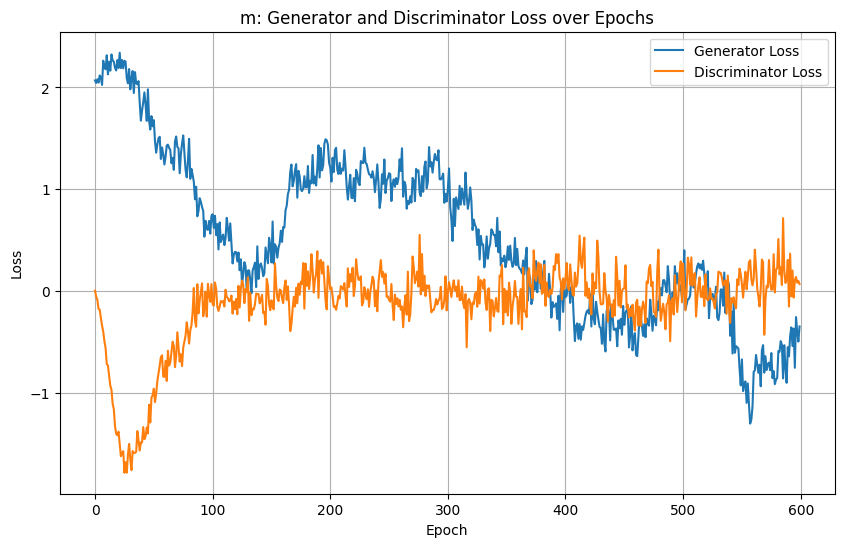


  8%|▊         | 1/13 [04:09<49:50, 249.23s/it]

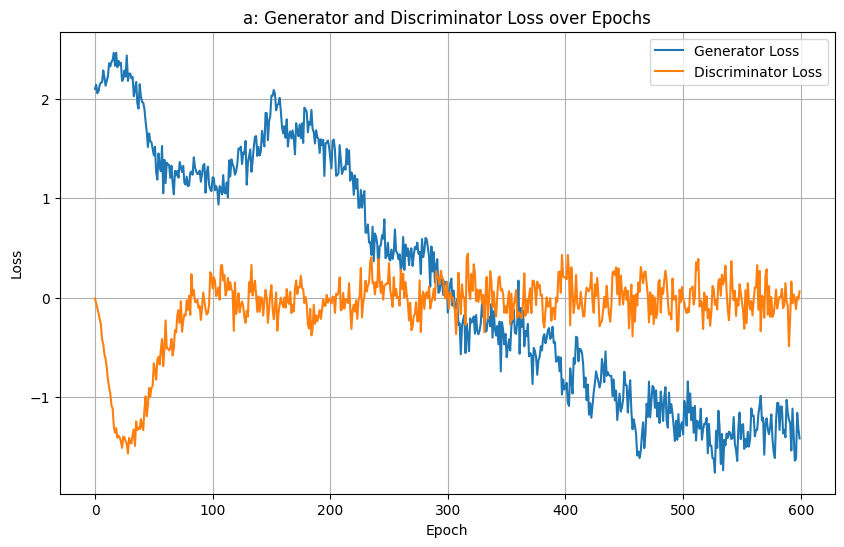


 15%|█▌        | 2/13 [11:41<1:07:37, 368.85s/it]

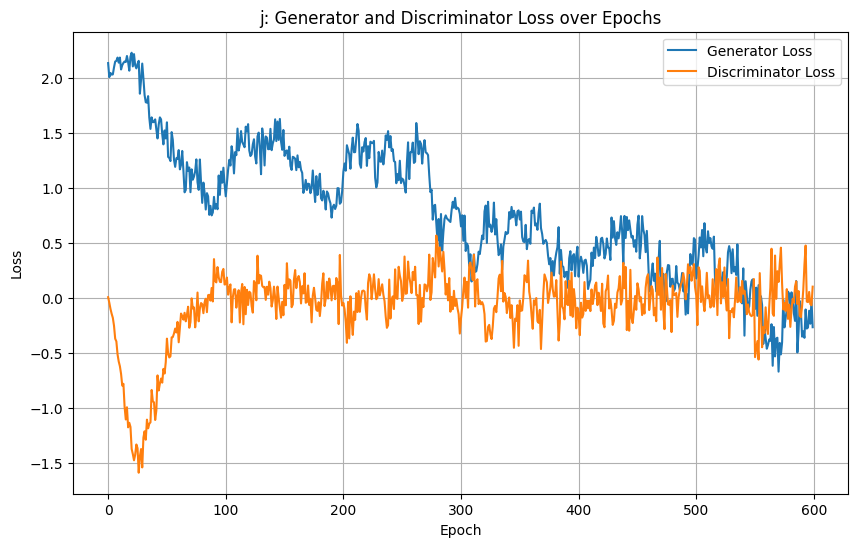


 23%|██▎       | 3/13 [14:35<46:37, 279.74s/it]  

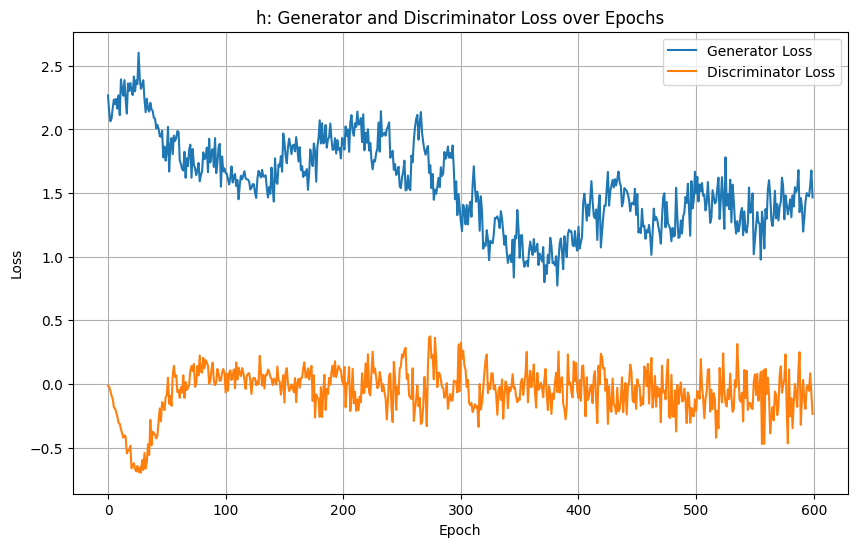


 31%|███       | 4/13 [18:13<38:17, 255.27s/it]

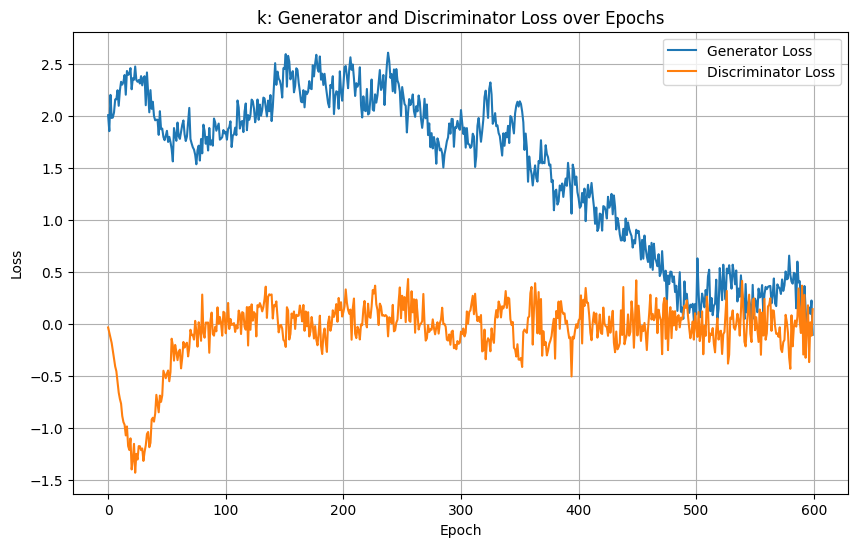


 38%|███▊      | 5/13 [21:26<31:04, 233.03s/it]

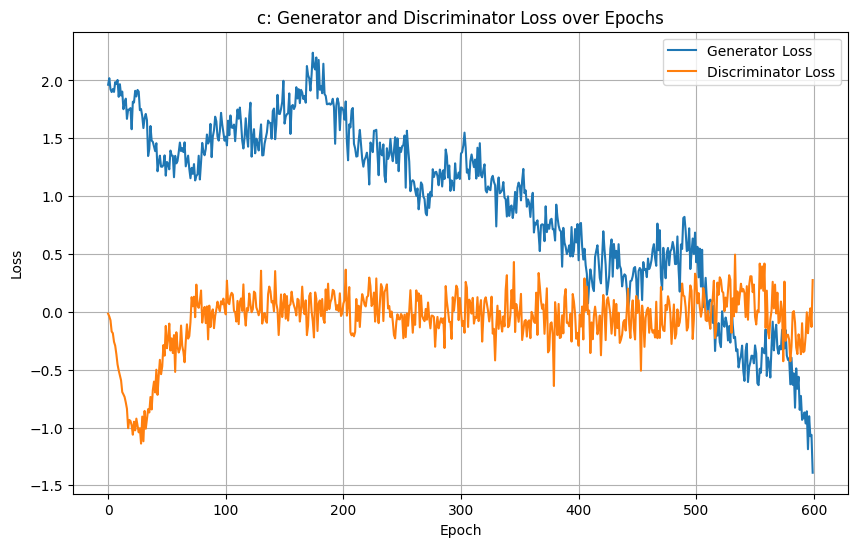


 46%|████▌     | 6/13 [24:29<25:10, 215.80s/it]

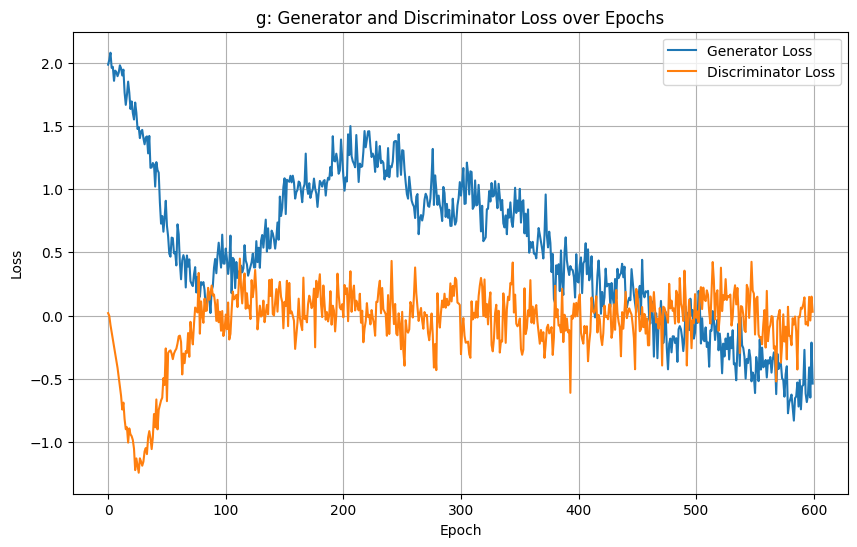


 54%|█████▍    | 7/13 [27:02<19:31, 195.28s/it]

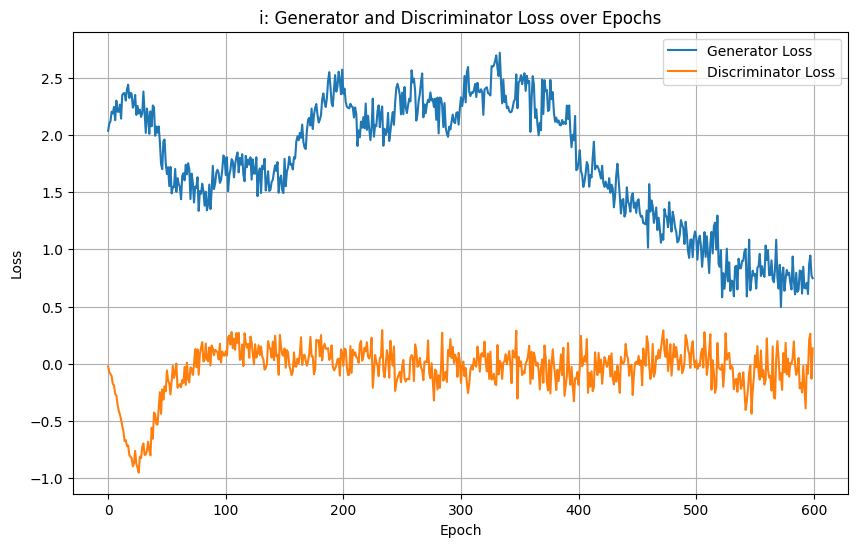


 62%|██████▏   | 8/13 [31:35<18:19, 219.95s/it]

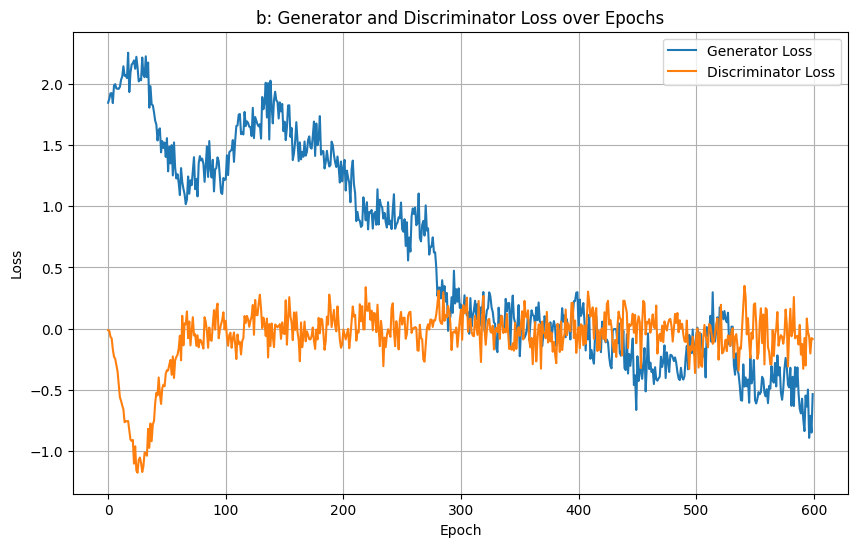


 69%|██████▉   | 9/13 [36:29<16:12, 243.20s/it]

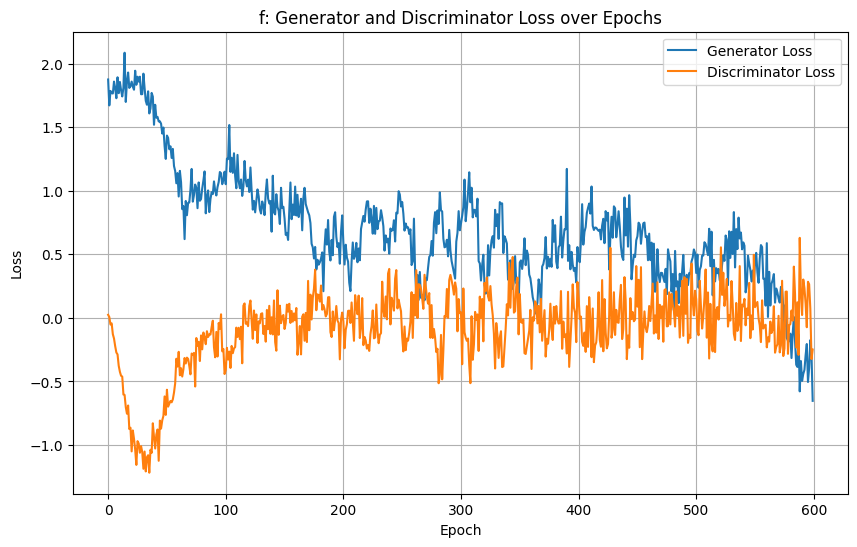


 77%|███████▋  | 10/13 [41:17<12:51, 257.14s/it]

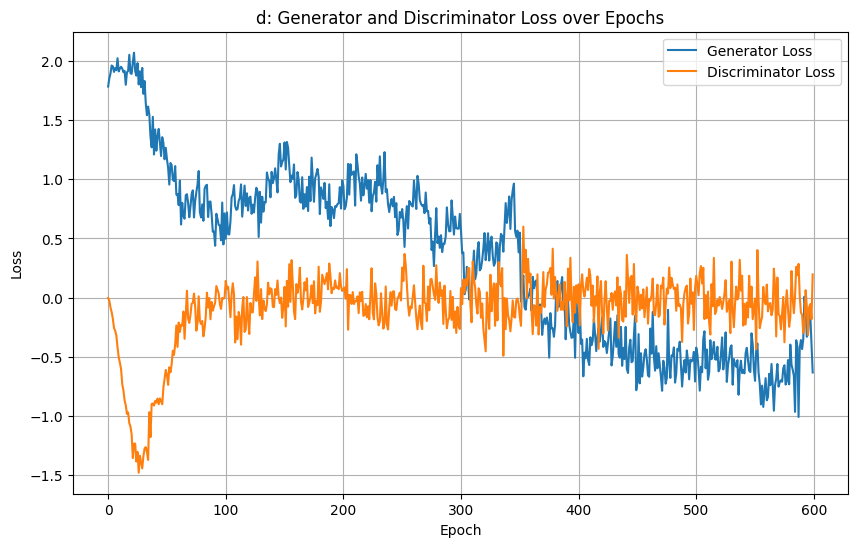


 85%|████████▍ | 11/13 [45:08<08:18, 249.20s/it]

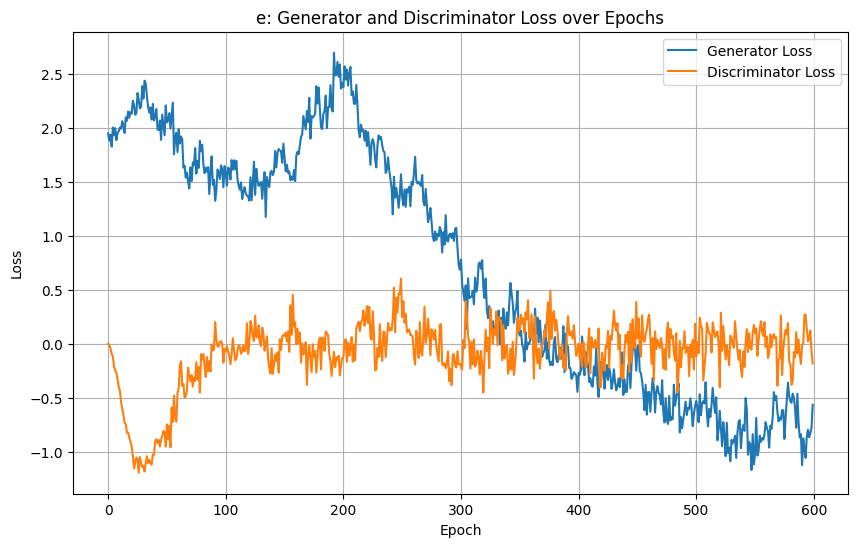


 92%|█████████▏| 12/13 [52:58<05:16, 316.13s/it]

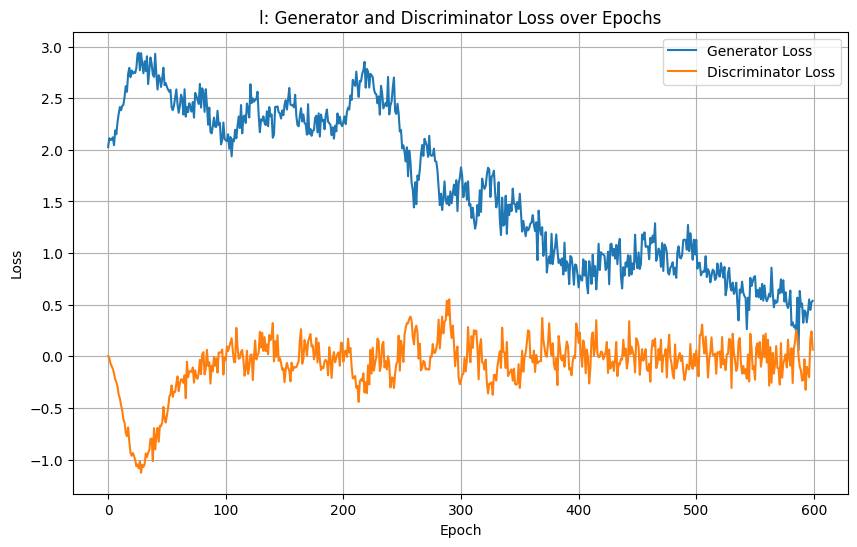


100%|██████████| 13/13 [57:46<00:00, 266.66s/it]


Final All Synthetic Data Shape: (130000, 63)


In [7]:
# 모든 합성 데이터를 저장할 DataFrame 초기화
all_synthetic_data = pd.DataFrame()

from sdv.single_table import CTGANSynthesizer
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdmetrics.reports.single_table._properties.column_shapes import ColumnShapes

# 각 Fraud_Type에 대해 합성 데이터 생성 및 저장
for fraud_type in tqdm(fraud_types):
    # 해당 Fraud_Type에 대한 서브셋 생성
    subset_all = saved_train[saved_train["Fraud_Type"] == fraud_type]

    N_CLS_PER_GEN = 10000
    subset = subset_all.copy()

    max_valid_date = pd.to_datetime('2024-09-01') # Replace with an appropriate date
    subset['Transaction_resumed_date'] = pd.to_datetime(subset['Transaction_resumed_date'])
    subset['Transaction_resumed_date'] = subset['Transaction_resumed_date'].where(subset['Transaction_resumed_date'] <= max_valid_date, max_valid_date)

    # Time_difference 열 제외 (초 단위로 변환된 컬럼만 사용)
    subset_all = subset_all.drop('Time_difference', axis=1)
    subset = subset.drop('Time_difference', axis=1)

    # 메타데이터 생성 및 모델 학습
    metadata = SingleTableMetadata()

    metadata.detect_from_dataframe(subset)
    metadata.set_primary_key(None)

    # 각 컬럼에 대해 데이터 타입 설정
    for column, sdtype in column_sdtypes.items():
        metadata.update_column(
            column_name=column,
            sdtype=sdtype
        )

    synthesizer = CTGANSynthesizer(
                            metadata,
                            epochs=600,
                            enforce_min_max_values=True,
                            enforce_rounding=True,
                            verbose=False,
                            cuda=True,
                            embedding_dim = 128, #default: 128
                            generator_lr=1e-4,
                            discriminator_lr=1e-4,
                            generator_dim=(256, 256),
                            discriminator_dim=(256, 256),
                           # pac = 5, #default: 10

                        )

    # 제약 걸기
    synthesizer.add_constraints(constraints=[
        ineq1, ineq2, ineq3, ineq4, ineq5,
        pos
    ])

    # 학습
    synthesizer.fit(subset)

    # 시각화
    tmp_loss = synthesizer.get_loss_values()
    plt.figure(figsize=(10, 6))
    plt.plot(tmp_loss.Epoch, tmp_loss['Generator Loss'], label='Generator Loss')#, marker='o')
    plt.plot(tmp_loss.Epoch, tmp_loss['Discriminator Loss'], label='Discriminator Loss')#, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(fraud_type + ': Generator and Discriminator Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 샘플링
    synthesizer.reset_sampling()
    synthetic_subset = synthesizer.sample(num_rows=N_CLS_PER_GEN)

    # 모델 저장
    model_name = '3_2_CTGAN_' + fraud_type + '.pkl'
    synthesizer.save(model_name)

    # 평가
    #diagnostic = run_diagnostic(subset_all, synthetic_subset, metadata,
    #                            verbose=False)
    #column_shape_property = ColumnShapes()
    #metadata_as_dict = metadata.to_dict()
    #report = column_shape_property._generate_details(subset_all, synthetic_subset, metadata_as_dict)

    #print()
    #print("Data Validity Score: ", round(diagnostic.get_score()*100, 4), '%')
    #print("Data Quality - Column_Shapes Score: ", round(report.Score.mean()*100, 4), '%')
    #print()

    # Time_difference_seconds를 다시 timedelta로 변환
    synthetic_subset['Time_difference'] = pd.to_timedelta(synthetic_subset['Time_difference_seconds'], unit='s')

    # Time_difference_seconds 컬럼 제거
    synthetic_subset = synthetic_subset.drop('Time_difference_seconds', axis=1)

    # 생성된 데이터를 all_synthetic_data에 추가
    all_synthetic_data = pd.concat([all_synthetic_data, synthetic_subset], ignore_index=True)
# 최종 결과 확인
print("\nFinal All Synthetic Data Shape:", all_synthetic_data.shape)

# 생성 조건 확인

In [8]:
import re

def is_valid_korean_text(text):
    # 한글 유니코드 범위: \uAC00-\uD7A3
    korean_regex = re.compile(r'^[\uAC00-\uD7A3]{2,5}$')
    return bool(korean_regex.match(text))

def is_valid_english_text_with_hyphen(text):
    # 형식: 알파벳 6글자-알파벳 7글자
    pattern = re.compile(r'^[a-zA-Z]{6}-[a-zA-Z]{7}$')
    return bool(pattern.match(text))

def is_valid_datetime_format(text):
    # 형식: YYYY-MM-DD HH:MM:SS
    text = str(text)
    pattern = re.compile(r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}$')
    return bool(pattern.match(text))

def is_zero_one(value):
    return value in [0, 1]

def is_valid_address(text):
    # 주소 형식: 2~4개의 단어 + 2개의 숫자 (위도와 경도)
    pattern = re.compile(r'^[가-힣a-zA-Z0-9]+(?:\s[가-힣a-zA-Z0-9]+){1,3}\s-?\d{1,3}\.\d+\s-?\d{1,3}\.\d+$')
    return bool(pattern.match(text))

def is_valid_10_letter_alphabet(text):
    # 알파벳 10글자 형식 검사
    pattern = re.compile(r'^[a-zA-Z]{10}$')
    return bool(pattern.match(text))

def is_valid_ipv4(text):
    # IPv4 정규 표현식
    pattern = re.compile(r'^((25[0-5]|2[0-4][0-9]|1[0-9]{2}|[1-9]?[0-9])\.){3}(25[0-5]|2[0-4][0-9]|1[0-9]{2}|[1-9]?[0-9])$')
    return bool(pattern.match(text))

def is_valid_hex_group(text):
    # 16진수 그룹 정규 표현식
    pattern = re.compile(r'^([0-9A-Fa-f]{2}[:-]){5}([0-9A-Fa-f]{2})$')
    return bool(pattern.match(text))

In [9]:
def check_valid(row):
    flag = 0
    #print(row['Customer_personal_identifier'])
    if is_valid_korean_text(row['Customer_personal_identifier']) and is_valid_english_text_with_hyphen(row['Customer_identification_number']):

        if all([is_valid_datetime_format(row[x]) for x in ['Customer_registration_datetime', 'Account_creation_datetime', 'Transaction_Datetime', 'Last_atm_transaction_datetime', 'Last_bank_branch_transaction_datetime', 'Transaction_resumed_date']]):

            if all([is_zero_one(row[x]) for x in ['Customer_flag_change_of_authentication_1', 'Customer_flag_change_of_authentication_2', 'Customer_flag_change_of_authentication_3', 'Customer_flag_change_of_authentication_4', 'Customer_rooting_jailbreak_indicator',
                                                'Customer_mobile_roaming_indicator', 'Customer_VPN_Indicator', 'Customer_flag_terminal_malicious_behavior_1', 'Customer_flag_terminal_malicious_behavior_2', 'Customer_flag_terminal_malicious_behavior_3',
                                                'Customer_flag_terminal_malicious_behavior_4', 'Customer_flag_terminal_malicious_behavior_5', 'Customer_flag_terminal_malicious_behavior_6', 'Customer_inquery_atm_limit', 'Customer_increase_atm_limit',
                                                'Account_indicator_release_limit_excess', 'Account_indicator_Openbanking', 'Account_release_suspention', 'Transaction_Failure_Status', 'Another_Person_Account', 'Unused_terminal_status',
                                                'Flag_deposit_more_than_tenMillion', 'Unused_account_status', 'Recipient_account_suspend_status', 'First_time_iOS_by_vulnerable_user']]):

                if is_valid_address(row['Location']) and is_valid_10_letter_alphabet(row['Recipient_Account_Number']) and is_valid_10_letter_alphabet(row['Account_account_number']) and is_valid_ipv4(row['IP_Address']) and is_valid_hex_group(row['MAC_Address']):

                    #if all([row[x].values[0] >= 0 for x in ['Account_initial_balance', 'Account_balance', 'Account_amount_daily_limit', 'Account_remaining_amount_daily_limit_exceeded', 'Account_one_month_max_amount',
                    #                                'Account_one_month_std_dev', 'Account_dawn_one_month_max_amount', 'Account_dawn_one_month_std_dev', 'Transaction_Amount', 'Transaction_num_connection_failure',
                    #                                'Distance', 'Number_of_transaction_with_the_account', 'Transaction_history_with_the_account']]):
                    if row['Customer_loan_type'] in ['a', 'b', 'c', 'd', 'e']:
                        if row['Channel'] in ['mobile', 'internet', 'ATM', 'Others']:
                            if row['Operating_System'] in ['Windows', 'macOS', 'Linux', 'Android', 'iOS', 'Others']:
                                if row['Error_Code'] in ['a', 'b', 'c', 'd', 'e', 'f']:
                                    if row['Type_General_Automatic'] in ['automatic', 'general']:
                                        if row['Access_Medium'] in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']:
                                            if row['Account_account_type'] in ['a', 'b', 'c', 'd']:
                                                if row['Customer_credit_rating'] in ['S', 'A', 'B', 'C', 'D', 'E']:
                                                    if row['Customer_Gender'] in ['female', 'male']:
                                                        if row['Fraud_Type'] in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm']:
                                                            #print("~~~~~~~~~~~~~~~~~~``")
                                                            return '1'
                                                        else:
                                                            return ("type")
                                                    else:
                                                        return("gender")
                                                else:
                                                    return("rating")
                                            else:
                                                return("Account_account_type")
                                        else:
                                            return("medium")
                                    else:
                                        return("automatic")
                                else:
                                    return("error")
                            else:
                                return("system")
                        else:
                            return("channel")
                    else:
                        return("loan")
                else:
                    return("valid_others")
            else:
                return("zero_one")
        else:
            return("datetime")
    else:
        return("personal")

In [10]:
tmp_syn_res = all_synthetic_data.copy()
tmp_syn_res['result'] = '0'
tmp_syn_res['result'] = tmp_syn_res.apply(lambda row: check_valid(row), axis=1)

candi = tmp_syn_res[tmp_syn_res.result != '1']
candi.result.value_counts()

,count
result,


# 저장

In [ ]:
all_synthetic_data.Fraud_Type.value_counts()

,count
Fraud_Type,
m,10000
a,10000
j,10000
h,10000
k,10000
c,10000
g,10000
i,10000
b,10000


In [ ]:
# 데이터 저장
save_path = '/content/drive/MyDrive/Colab Notebooks/fsi/processed_data'
all_synthetic_data.to_csv(save_path + '/ctgan_syn_data.csv', index=False)